## Can RL be used for Classification?
*Let's find out...*

In [1]:
def run_dqn (df,y,eps,ws,bs,lr):
    import os

    import numpy as np
    import tensorflow_datasets as tfds
    from imbDRL.agents.ddqn import TrainDDQN
    from imbDRL.data import get_train_test_val
    from imbDRL.utils import rounded_dict
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.layers import Dense, Dropout

    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU is faster than GPU on structured data

    episodes = eps  # Total number of episodes
    warmup_steps = ws  # Amount of warmup steps to collect data with random policy
    memory_length = warmup_steps  # Max length of the Replay Memory
    batch_size = bs
    collect_steps_per_episode = 500
    collect_every = 500

    target_update_period = 400  # Period to overwrite the target Q-network with the default Q-network
    target_update_tau = 1  # Soften the target model update
    n_step_update = 1

    layers = [Dense(256, activation="relu"), Dropout(0.2),
              Dense(256, activation="relu"), Dropout(0.2),
              Dense(2, activation=None)]  # No activation, pure Q-values

    learning_rate = lr  # Learning rate
    gamma = 0.0  # Discount factor
    min_epsilon = 0.5  # Minimal and final chance of choosing random action
    decay_episodes = episodes // 10  # Number of episodes to decay from 1.0 to `min_epsilon``

    min_class = [1]  # Minority classes
    maj_class = [0]  # Majority classes

    X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), y.to_numpy(), stratify=y, test_size=0.2)
    X_train, y_train, X_test, y_test, X_val, y_val = get_train_test_val(X_train, y_train, X_test, y_test,
                                                                        min_class, maj_class, val_frac=0.2)

    model = TrainDDQN(episodes, warmup_steps, learning_rate, gamma, min_epsilon, decay_episodes, target_update_period=target_update_period,
                      target_update_tau=target_update_tau, batch_size=batch_size, collect_steps_per_episode=collect_steps_per_episode,
                      memory_length=memory_length, collect_every=collect_every, n_step_update=n_step_update,model_path='modelfiles.pkl')

    model.compile_model(X_train, y_train, layers)
    #model.q_net.summary()
    model.train(X_val, y_val, "F1")

    stats = model.evaluate(X_test, y_test, X_train, y_train)
    return (rounded_dict(stats))


In [4]:
from imbDRL.data import get_train_test_val
from imbDRL.utils import rounded_dict
from sklearn.model_selection import train_test_split

In [6]:
import pandas as pd
import numpy as np
df=pd.read_csv("Cleaned_kidney_with_feature_engineering.csv")

In [7]:
df.columns


Index(['Unnamed: 0', 'age', 'blood pressure', 'specific gravity', 'albumin',
       'sugar', 'red blood cells', 'pus cell', 'pus cell clumps', 'bacteria',
       'blood glucose random', 'blood urea', 'serum creatinine', 'sodium',
       'potassium', 'haemoglobin', 'packed cell volume',
       'white blood cell count', 'red blood cell count', 'hypertension',
       'diabetes mellitus', 'coronary artery disease', 'appetite',
       'pedal edema', 'anemia', 'class'],
      dtype='object')

In [8]:
y = df['class']
df = df.drop(columns=['Unnamed: 0','class'])
df = df.astype(np.float64)

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000


2022-05-30 19:05:44.634222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 19:05:44.634256: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 19:05:44.634281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-05-30 19:05:44.635404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


10_000 frames collected!
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Training the DDQN:   5%|▌         | 500/10000 [00:00<00:07, 1205.96it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Training the DDQN: 100%|██████████| 10000/10000 [00:22<00:00, 452.21it/s]

Best score: 0.545455!


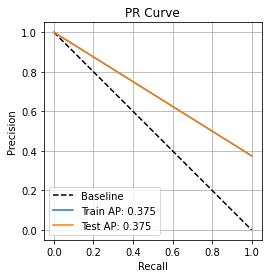

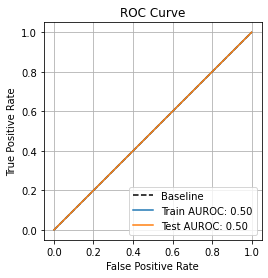

{'Gmean': 0.0,
 'F1': 0.545455,
 'Precision': 0.375,
 'Recall': 1.0,
 'TP': 30,
 'TN': 0,
 'FP': 50,
 'FN': 0}

In [9]:
# Running wuth 10000 episodes and 10000 warmup steps , batch size 10,learning rate = 0.005
run_dqn (df,y,10000,10000,10,0.005)

Lets test the model with same episodes and warm up steps but by changing batch size and learning rate 


Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
100_000 frames collected!


Training the DDQN: 100%|██████████| 100000/100000 [03:42<00:00, 449.73it/s]

Best score: 0.545455!


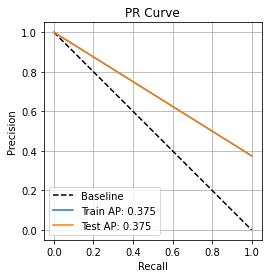

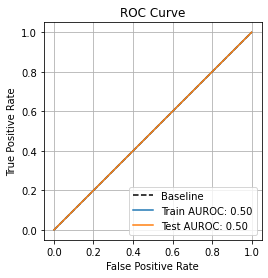

{'Gmean': 0.0,
 'F1': 0.545455,
 'Precision': 0.375,
 'Recall': 1.0,
 'TP': 30,
 'TN': 0,
 'FP': 50,
 'FN': 0}

In [10]:
run_dqn (df,y,100000,100000,25,0.05)

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
10_000 frames collected!


Training the DDQN: 100%|██████████| 10000/10000 [00:26<00:00, 378.40it/s]

Best score: 0.545455!


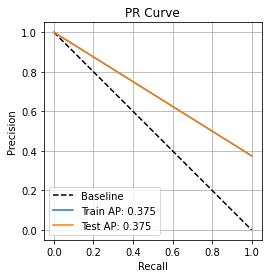

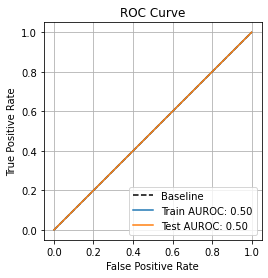

{'Gmean': 0.0,
 'F1': 0.545455,
 'Precision': 0.375,
 'Recall': 1.0,
 'TP': 30,
 'TN': 0,
 'FP': 50,
 'FN': 0}

In [11]:
run_dqn (df,y,10000,10000,50,0.005)

In [22]:
batch_list = [10,15,20,25,50]

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_8 (Dropout)          multiple                  0         
_________________________________________________________________
dense_13 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_9 (Dropout)          multiple                  0         
_________________________________________________________________
dense_14 (Dense)             multiple                  514       
Total params: 72,706
Trainable params: 72,706
Non-trainable params: 0
_________________________________________________________________
10_00

Training the DDQN: 100%|██████████| 10000/10000 [00:23<00:00, 427.76it/s]

Best score: 0.545455!


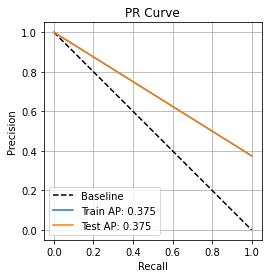

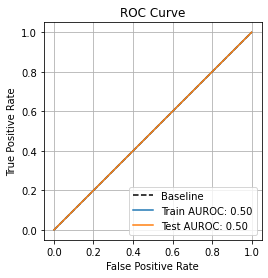

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_11 (Dropout)         multiple                  0         
_________________________________________________________________
dense_17 (Dense)             multiple                  514       
Total params: 72,706
Trainable params

Training the DDQN: 100%|██████████| 10000/10000 [00:23<00:00, 433.42it/s]

Best score: 0.545455!


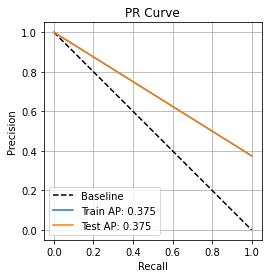

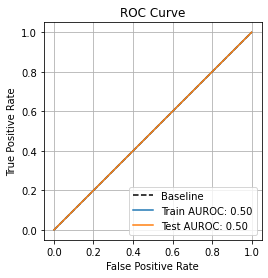

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_12 (Dropout)         multiple                  0         
_________________________________________________________________
dense_19 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_13 (Dropout)         multiple                  0         
_________________________________________________________________
dense_20 (Dense)             multiple                  514       
Total params: 72,706
Trainable params

Training the DDQN: 100%|██████████| 10000/10000 [00:23<00:00, 419.53it/s]

Best score: 0.545455!


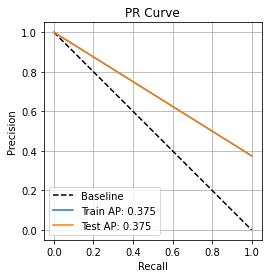

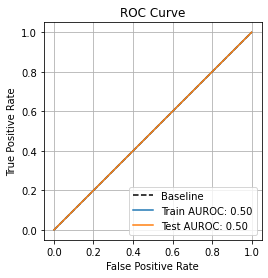

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_14 (Dropout)         multiple                  0         
_________________________________________________________________
dense_22 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_15 (Dropout)         multiple                  0         
_________________________________________________________________
dense_23 (Dense)             multiple                  514       
Total params: 72,706
Trainable params

Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 413.20it/s]

Best score: 0.545455!


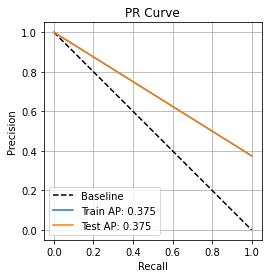

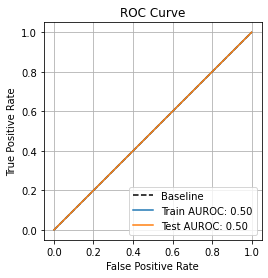

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_16 (Dropout)         multiple                  0         
_________________________________________________________________
dense_25 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_17 (Dropout)         multiple                  0         
_________________________________________________________________
dense_26 (Dense)             multiple                  514       
Total params: 72,706
Trainable params

Training the DDQN: 100%|██████████| 10000/10000 [00:27<00:00, 362.68it/s]

Best score: 0.545455!


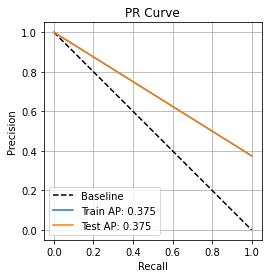

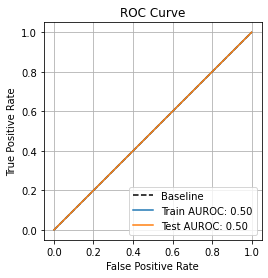

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}


In [24]:
for i in batch_list :
    run_dqn (df,y,10000,10000,i,0.005)

We can see batch size does not have any impact on performance

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_22 (Dropout)         multiple                  0         
_________________________________________________________________
dense_34 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_23 (Dropout)         multiple                  0         
_________________________________________________________________
dense_35 (Dense)             multiple                  514       
Total params: 72,706
Trainable params: 72,706
Non-trainable params: 0
_________________________________________________________________
10_0


Training the DDQN:   0%|          | 0/10000 [00:00<?, ?it/s]


Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 407.60it/s]


Best score: 0.545455!


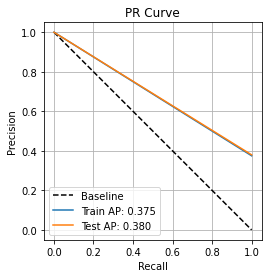

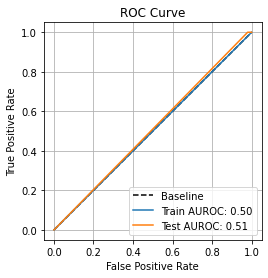

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_24 (Dropout)         multiple                  0         
_________________________________________________________________
dense_37 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_25 (Dropout)         multiple                  0         
_________________________________________________________________
dense_38 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 10000/10000 [00:25<00:00, 392.25it/s]


Best score: 0.545455!


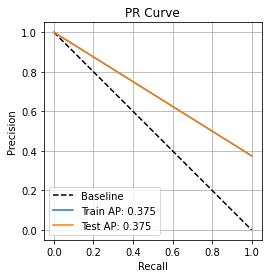

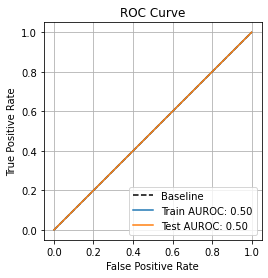

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
dense_40 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_27 (Dropout)         multiple                  0         
_________________________________________________________________
dense_41 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 10000/10000 [00:25<00:00, 397.38it/s]

Best score: 0.545455!


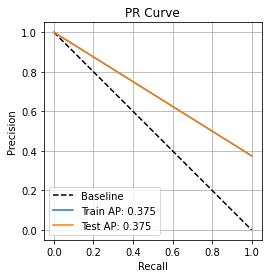

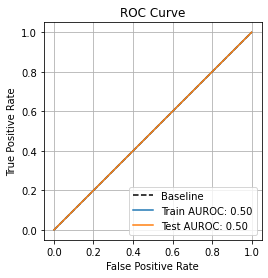

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_28 (Dropout)         multiple                  0         
_________________________________________________________________
dense_43 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_29 (Dropout)         multiple                  0         
_________________________________________________________________
dense_44 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 408.59it/s]

Best score: 0.545455!


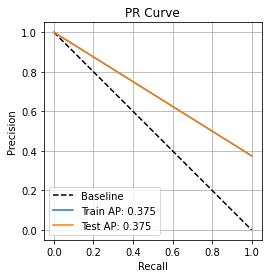

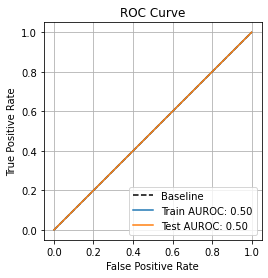

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}


In [31]:
lr_list=[0.5,0.005,0.0005,0.00005]
for i in lr_list :   
    run_dqn (df,y,10000,10000,25,i)

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_30 (Dropout)         multiple                  0         
_________________________________________________________________
dense_46 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_31 (Dropout)         multiple                  0         
_________________________________________________________________
dense_47 (Dense)             multiple                  514       
Total params: 72,706
Trainable params: 72,706
Non-trainable params: 0
_________________________________________________________________
10_0


Training the DDQN:   0%|          | 0/100 [00:00<?, ?it/s]
Training the DDQN: 500it [00:02, 241.54it/s]              

Best score: 0.000000!


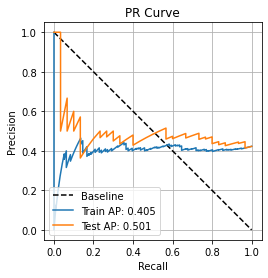

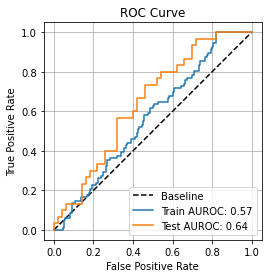

{'Gmean': 0.0, 'F1': 0.0, 'Precision': 0, 'Recall': 0.0, 'TP': 0, 'TN': 50, 'FP': 0, 'FN': 30}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_32 (Dropout)         multiple                  0         
_________________________________________________________________
dense_49 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_33 (Dropout)         multiple                  0         
_________________________________________________________________
dense_50 (Dense)             multiple                  514       
Total params: 72,706
Trainable params: 72,706


Training the DDQN: 100%|██████████| 1000/1000 [00:04<00:00, 241.84it/s]

Best score: 0.545455!


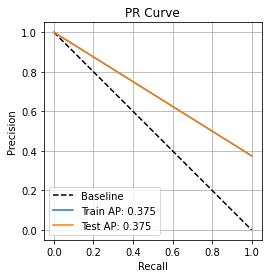

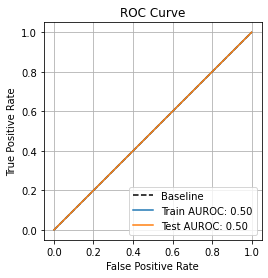

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_34 (Dropout)         multiple                  0         
_________________________________________________________________
dense_52 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_35 (Dropout)         multiple                  0         
_________________________________________________________________
dense_53 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 416.65it/s]

Best score: 0.545455!


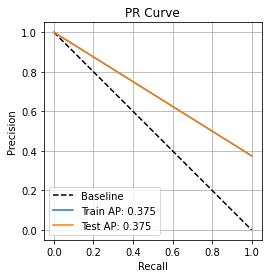

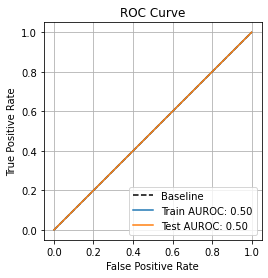

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_36 (Dropout)         multiple                  0         
_________________________________________________________________
dense_55 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
dense_56 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 100000/100000 [03:48<00:00, 437.55it/s]

Best score: 0.545455!


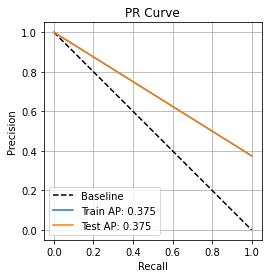

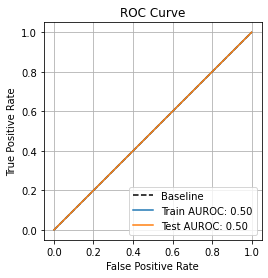

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}


In [32]:
# same testing for episodes and learning 
episodes_list=[100,1000,10000,100000]
for i in episodes_list :
    run_dqn (df,y,i,10000,25,0.005)

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_38 (Dropout)         multiple                  0         
_________________________________________________________________
dense_58 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_39 (Dropout)         multiple                  0         
_________________________________________________________________
dense_59 (Dense)             multiple                  514       
Total params: 72,706
Trainable params: 72,706
Non-trainable params: 0
_________________________________________________________________
100 


Training the DDQN: 100%|██████████| 10000/10000 [00:25<00:00, 392.75it/s]

Best score: 0.545455!


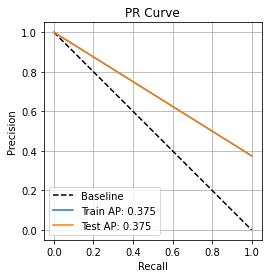

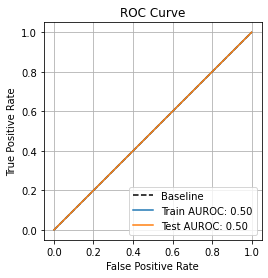

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_40 (Dropout)         multiple                  0         
_________________________________________________________________
dense_61 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_41 (Dropout)         multiple                  0         
_________________________________________________________________
dense_62 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 412.70it/s]

Best score: 0.554217!


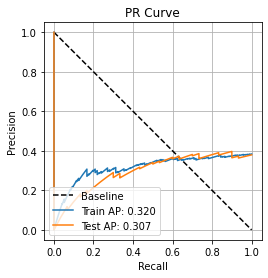

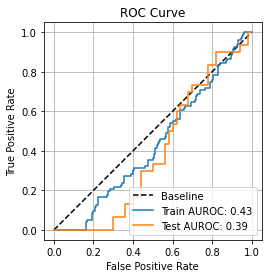

{'Gmean': 0.361478, 'F1': 0.554455, 'Precision': 0.394366, 'Recall': 0.933333, 'TP': 28, 'TN': 7, 'FP': 43, 'FN': 2}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_42 (Dropout)         multiple                  0         
_________________________________________________________________
dense_64 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_43 (Dropout)         multiple                  0         
_________________________________________________________________
dense_65 (Dense)             multiple                  514       
Total params: 72,706
Tr


Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 409.25it/s]

Best score: 0.545455!


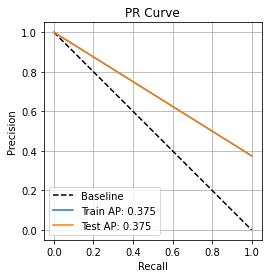

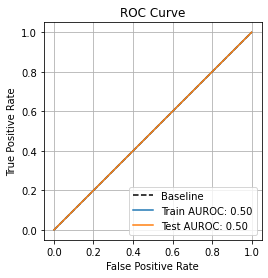

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}
Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_44 (Dropout)         multiple                  0         
_________________________________________________________________
dense_67 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_45 (Dropout)         multiple                  0         
_________________________________________________________________
dense_68 (Dense)             multiple                  514       
Total params: 72,706
Trainable param


Training the DDQN: 100%|██████████| 10000/10000 [00:25<00:00, 390.32it/s]

Best score: 0.545455!


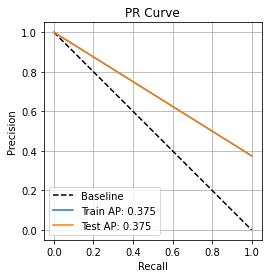

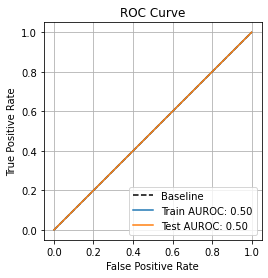

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}


In [33]:
learning_list=[100,1000,10000,100000]
for i in learning_list :
    run_dqn (df,y,10000,i,25,0.005)

After all the analysis learning rate to 10000 and episodes 10000 seems to be best one 

Imbalance ratio `p`:
	train:      n=96, p=0.600000
	test:       n=30, p=0.600000
	validation: n=24, p=0.600000
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             multiple                  6400      
_________________________________________________________________
dropout_56 (Dropout)         multiple                  0         
_________________________________________________________________
dense_85 (Dense)             multiple                  65792     
_________________________________________________________________
dropout_57 (Dropout)         multiple                  0         
_________________________________________________________________
dense_86 (Dense)             multiple                  514       
Total params: 72,706
Trainable params: 72,706
Non-trainable params: 0
_________________________________________________________________
1_00


Training the DDQN: 100%|██████████| 10000/10000 [00:24<00:00, 402.38it/s]

Best score: 0.545455!


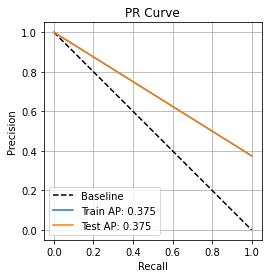

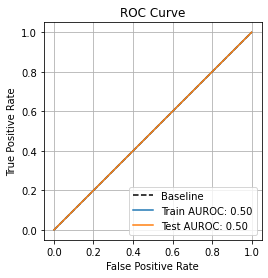

{'Gmean': 0.0, 'F1': 0.545455, 'Precision': 0.375, 'Recall': 1.0, 'TP': 30, 'TN': 0, 'FP': 50, 'FN': 0}


In [39]:
run_dqn (df,y,10000,1000,25,0.005)

In [46]:
data_pokemon=pd.read_csv("DQN/pokemon_cleaned.csv")

In [48]:
data_pokemon.columns

Index(['Unnamed: 0', '#', 'Name', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Type 1_Bug',
       'Type 1_Dark', 'Type 1_Dragon', 'Type 1_Electric', 'Type 1_Fairy',
       'Type 1_Fighting', 'Type 1_Fire', 'Type 1_Flying', 'Type 1_Ghost',
       'Type 1_Grass', 'Type 1_Ground', 'Type 1_Ice', 'Type 1_Normal',
       'Type 1_Poison', 'Type 1_Psychic', 'Type 1_Rock', 'Type 1_Steel',
       'Type 1_Water', 'Type 2_Bug', 'Type 2_Dark', 'Type 2_Dragon',
       'Type 2_Electric', 'Type 2_Fairy', 'Type 2_Fighting', 'Type 2_Fire',
       'Type 2_Flying', 'Type 2_Ghost', 'Type 2_Grass', 'Type 2_Ground',
       'Type 2_Ice', 'Type 2_None', 'Type 2_Normal', 'Type 2_Poison',
       'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel', 'Type 2_Water'],
      dtype='object')

In [49]:
data_pokemon = data_pokemon.drop(columns=['Unnamed: 0','#'])

In [50]:
data_pokemon.columns

Index(['Name', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def',
       'Speed', 'Generation', 'Legendary', 'Type 1_Bug', 'Type 1_Dark',
       'Type 1_Dragon', 'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting',
       'Type 1_Fire', 'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass',
       'Type 1_Ground', 'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison',
       'Type 1_Psychic', 'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water',
       'Type 2_Bug', 'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric',
       'Type 2_Fairy', 'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying',
       'Type 2_Ghost', 'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice',
       'Type 2_None', 'Type 2_Normal', 'Type 2_Poison', 'Type 2_Psychic',
       'Type 2_Rock', 'Type 2_Steel', 'Type 2_Water'],
      dtype='object')

In [52]:
normal = data_pokemon.loc[data_pokemon["Legendary"] == 0]
legendary = data_pokemon.loc[data_pokemon["Legendary"] == 1]
sampledNormal = normal.sample(100)

In [64]:
poki_X = pd.concat([legendary, sampledNormal])
poki_X = poki_X.sample(frac=1)
poki_y = poki_X['Legendary']
poki_X = poki_X.drop(columns=['Legendary','Name'])

In [65]:
poki_X.columns

Index(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation', 'Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon',
       'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire',
       'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground',
       'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic',
       'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug',
       'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy',
       'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost',
       'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice', 'Type 2_None',
       'Type 2_Normal', 'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock',
       'Type 2_Steel', 'Type 2_Water'],
      dtype='object')

In [66]:
poki_y

579    0
483    0
360    0
625    0
270    1
      ..
519    0
739    0
214    0
667    0
492    0
Name: Legendary, Length: 165, dtype: int64

Imbalance ratio `p`:
	train:      n=41, p=0.640625
	test:       n=13, p=0.650000
	validation: n=11, p=0.687500
100_000 frames collected!



Training the DDQN: 100%|██████████| 100000/100000 [03:56<00:00, 423.17it/s]

Best score: 0.578947!


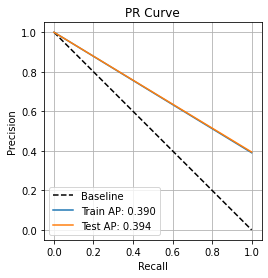

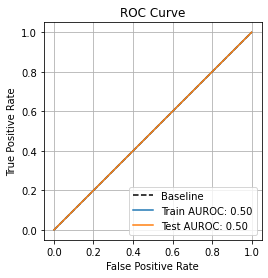

{'Gmean': 0.0,
 'F1': 0.565217,
 'Precision': 0.393939,
 'Recall': 1.0,
 'TP': 13,
 'TN': 0,
 'FP': 20,
 'FN': 0}

In [68]:
run_dqn (poki_X,poki_y,100000,100000,25,0.005)